**Context**

Sebuah perusahaan real estate memiliki data penjualan dari tahun 2016-2018, perusahaan ingin memiliki pengetahuan tentang penyebaran rumah-rumah berdasarkan tipe dan lokasinya. Jadi ketika seorang customer datang ingin membeli rumah dengan keinginan tertentu, agent real estate bisa mengetahui rumah mana yang cocok untuk customer tersebut


**Goals**

Perusahaan ingin memiliki kemampuan untuk memberikan rekomendasi rumah yang cocok untuk tiap customer nya, sehingga dapat meningkatkan penjualan melalui perusahaan tersebut

**Analytic Approach**

Jadi kita melakukan uji statistik dengan bantuan visualisasi agar proses dari analysis lebih mudah di interpretasikan

**Data Understanding**

Ini adalah kumpulan data yang dibuat oleh Tony Pino.

Itu diambil dari hasil yang tersedia untuk umum yang diposting setiap minggu dari Domain.com.au. Dia membersihkannya dengan baik, dan sekarang terserah Anda untuk membuat keajaiban analisis data. Dataset tersebut meliputi Alamat, Jenis Properti, Pinggiran Kota, Cara Penjualan, Kamar, Harga, Agen Real Estate, Tanggal Penjualan dan Jarak dari C.B.D.

https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

In [56]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Cleaning
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import datetime
import missingno

# Statistics
from scipy.stats import shapiro
from scipy.stats import kruskal

pd.options.display.max_columns = None

# Data

In [2]:
df=pd.read_csv('melb_data.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [3]:
df.shape

(13580, 21)

## Data Cleaning

In [4]:
df.drop(columns=['Bedroom2','YearBuilt','Propertycount','Address'],inplace=True)

kolom-kolom yang di drop:
* Bedroom 2 : isi dari data ini sama dengan di kolom Rooms, jadi kita menggunakan salah satu nya saja
* YearBuilt : di drop karena memiliki missing value yang cukup banyak dan tidak bisa di iisi berdassarkan domain knowledge
* Propertycount : tidak ada penjelasan tentang kolom ini pada kaggle, lebih baik di drop karena tidak digunakan juga untuk analisa
* Address : karena analysis ini bukan tentang customer profile jadi kita drop karena tidak digunakan untuk analysis ini

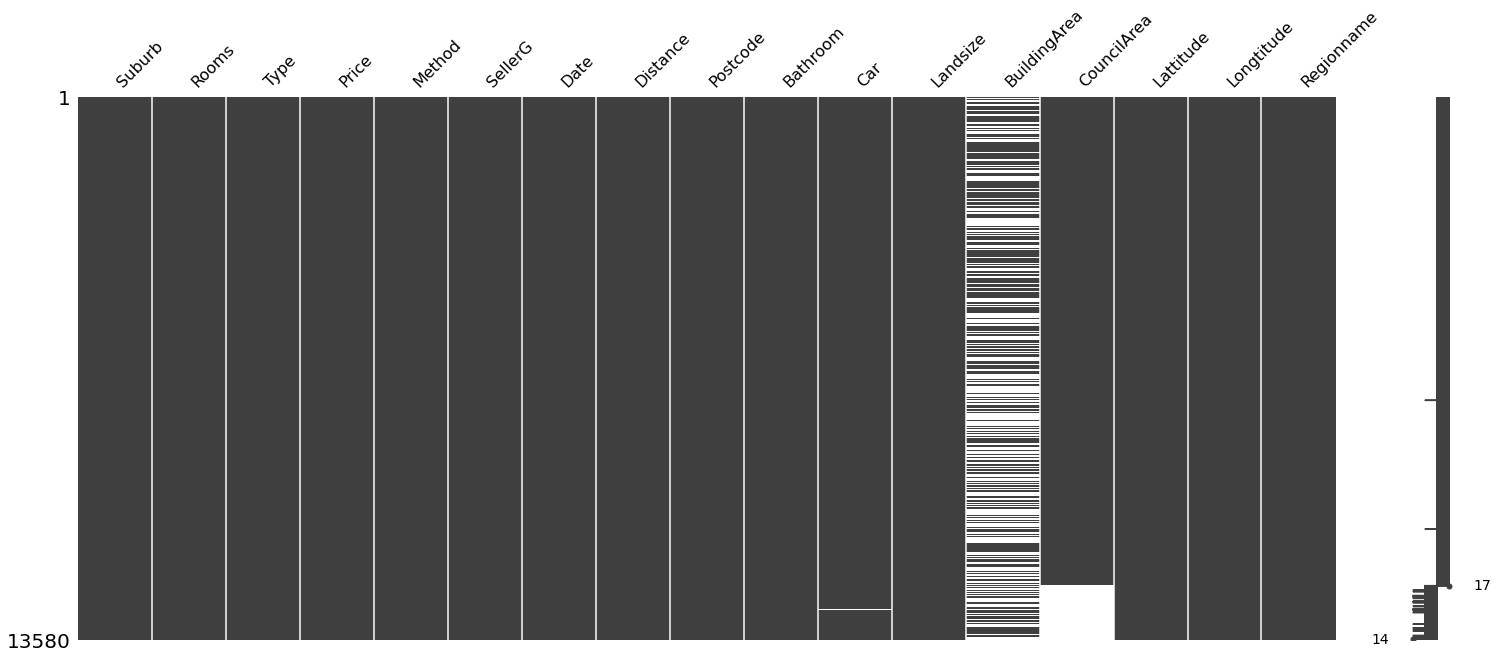

In [5]:
missingno.matrix(df)
plt.show()

bisa dilihat bahwa missing value pada data ini tidak saling berkorelasi, tidak ada pattern juga yang menunjukan penyebab data tersebut kosong. kecuali kolom council area bahwa seluruh missing value pada kolom tersebut berada di akhir data.

In [6]:
df.isna().sum()

Suburb             0
Rooms              0
Type               0
Price              0
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bathroom           0
Car               62
Landsize           0
BuildingArea    6450
CouncilArea     1369
Lattitude          0
Longtitude         0
Regionname         0
dtype: int64

In [7]:
# mengisi missing value kolom car menggunakan median
df['Car']=df['Car'].fillna(df['Car'].median())

In [8]:
# mengisi missing value pada kolom Council Area dengan 'NC'untuk menandai bahwa itu missing value tapi tetap bisa analysis
df['CouncilArea'].fillna('NC',inplace=True)

In [9]:
# mengisi missing value pada building area dengan KNN Imputer dengan kolom landsize dan rooms
knn_imputer=KNNImputer()
impute=pd.DataFrame(knn_imputer.fit_transform(df[['BuildingArea','Landsize','Rooms']]))
impute.columns = ['BuildingArea','Landsize','Rooms']

In [10]:
# mengubah kolom Builiding area dengan yang sudah di impute
df.drop(columns=['BuildingArea','Landsize','Rooms'],inplace=True)
df=pd.concat([df,impute],axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Suburb        13580 non-null  object 
 1   Type          13580 non-null  object 
 2   Price         13580 non-null  float64
 3   Method        13580 non-null  object 
 4   SellerG       13580 non-null  object 
 5   Date          13580 non-null  object 
 6   Distance      13580 non-null  float64
 7   Postcode      13580 non-null  float64
 8   Bathroom      13580 non-null  float64
 9   Car           13580 non-null  float64
 10  CouncilArea   13580 non-null  object 
 11  Lattitude     13580 non-null  float64
 12  Longtitude    13580 non-null  float64
 13  Regionname    13580 non-null  object 
 14  BuildingArea  13580 non-null  float64
 15  Landsize      13580 non-null  float64
 16  Rooms         13580 non-null  float64
dtypes: float64(10), object(7)
memory usage: 1.8+ MB


In [12]:
# Merubah tipe data sesuai dengan isi dari datanya
df['Car']=df['Car'].astype('int')
df['Date']=pd.to_datetime(df['Date'])
df['Bathroom']=df['Bathroom'].astype('int')
df['Rooms']=df['Rooms'].astype('int')
df['Postcode']=df['Postcode'].astype('str')

In [13]:
df.describe()

,Price,Distance,Bathroom,Car,Lattitude,Longtitude,BuildingArea,Landsize,Rooms
count,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000
mean,1.075684e+06,10.137776,1.534242,1.611856,-37.809203,144.995216,164.628641,558.416127,2.937997
std,6.393107e+05,5.868725,0.691712,0.960793,0.079260,0.103916,445.609024,3990.669241,0.955748
min,8.500000e+04,0.000000,0.000000,0.000000,-38.182550,144.431810,0.000000,0.000000,1.000000
25%,6.500000e+05,6.100000,1.000000,1.000000,-37.856822,144.929600,105.800000,177.000000,2.000000
50%,9.030000e+05,9.200000,1.000000,2.000000,-37.802355,145.000100,136.000000,440.000000,3.000000
75%,1.330000e+06,13.000000,2.000000,2.000000,-37.756400,145.058305,181.000000,651.000000,3.000000
max,9.000000e+06,48.100000,8.000000,10.000000,-37.408530,145.526350,44515.000000,433014.000000,10.000000


Ada anomali disini, bisa dilihat bahwa nilai minimum dari kolom buildingarea dan landsize adalah 0. ada kemungkinan nilai tersebut adalah missing value

In [14]:
df.describe(include='object')

,Suburb,Type,Method,SellerG,Postcode,CouncilArea,Regionname
count,13580,13580,13580,13580,13580,13580,13580
unique,314,3,5,268,198,34,8
top,Reservoir,h,S,Nelson,3073.0,NC,Southern Metropolitan
freq,359,9449,9022,1565,359,1369,4695


# Data Distribution

In [15]:
kolom=['Price','Distance','Rooms','Landsize','BuildingArea','Bathroom','Car']
distribusi=[]
for i in kolom:
    stats, pval=shapiro(df[i])
    print(stats,'\n','nilai P-Value :', pval)
    if pval>0.05:
        distribusi.append('normal')
    else:
        distribusi.append(' tidak normal')
        
pd.DataFrame(distribusi, index=kolom)

0.8328601717948914 
 nilai P-Value : 0.0
0.8876904249191284 
 nilai P-Value : 0.0
0.8982620239257812 
 nilai P-Value : 0.0
0.030498206615447998 
 nilai P-Value : 0.0
0.06299525499343872 
 nilai P-Value : 0.0
0.7250557541847229 
 nilai P-Value : 0.0
0.8226697444915771 
 nilai P-Value : 0.0


C:\Users\RynPyCua\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,0
Price,tidak normal
Distance,tidak normal
Rooms,tidak normal
Landsize,tidak normal
BuildingArea,tidak normal
Bathroom,tidak normal
Car,tidak normal


Berdasarkan uji normalitas menggunakan Shapiro, seluruh kolom numerical di data ini tidak ada yang distribusi nya normal

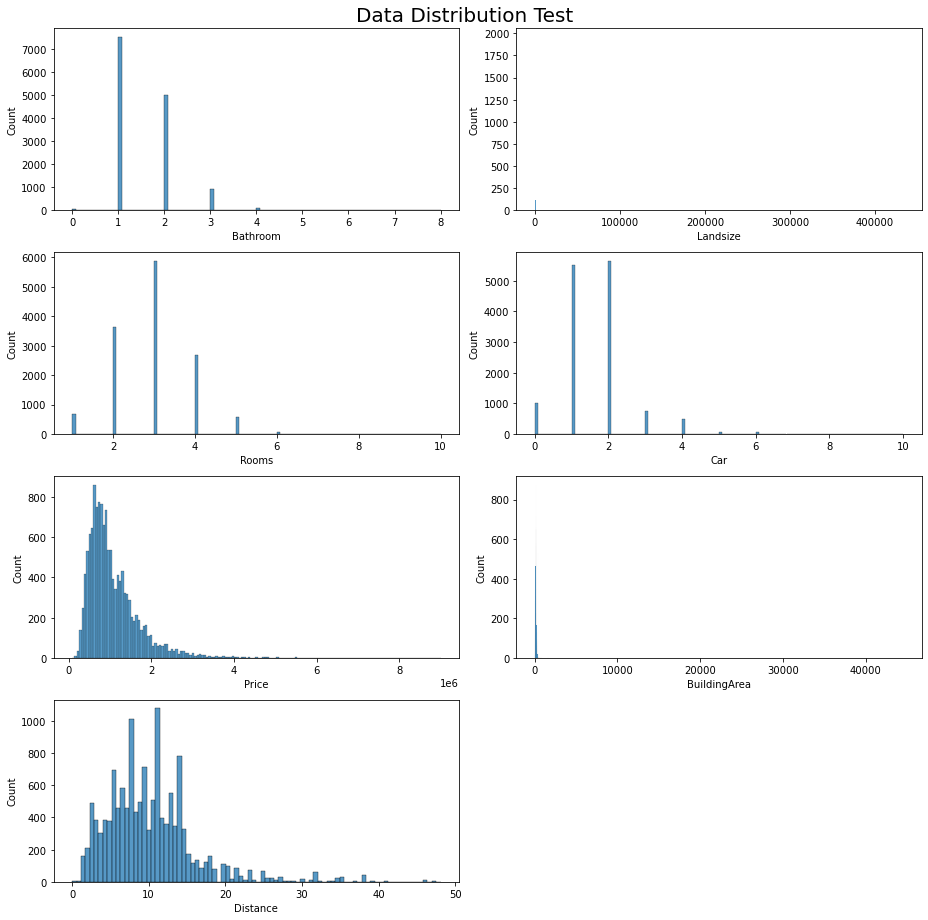

In [16]:
plt.figure(figsize=(13,13))
plt.subplot(421)
sns.histplot(df['Bathroom'])

plt.subplot(422)
sns.histplot(df['Landsize'])

plt.subplot(423)
sns.histplot(df['Rooms'])

plt.subplot(424)
sns.histplot(df['Car'])

plt.subplot(425)
sns.histplot(df['Price'])

plt.subplot(426)
sns.histplot(df['BuildingArea'])

plt.subplot(427)
sns.histplot(df['Distance'])


plt.suptitle('Data Distribution Test',size=20)
plt.tight_layout()

C:\Users\RynPyCua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\RynPyCua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\RynPyCua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\RynPyCua\anac

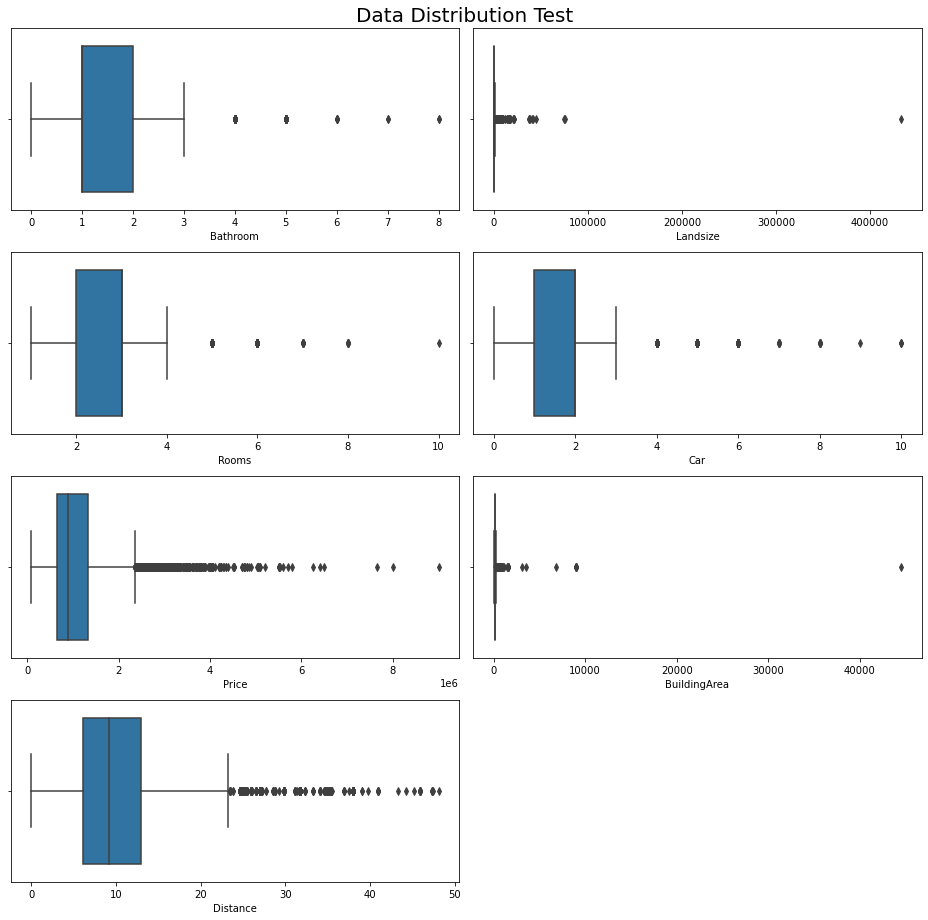

In [17]:
plt.figure(figsize=(13,13))
plt.subplot(421)
sns.boxplot(df['Bathroom'])

plt.subplot(422)
sns.boxplot(df['Landsize'])

plt.subplot(423)
sns.boxplot(df['Rooms'])

plt.subplot(424)
sns.boxplot(df['Car'])

plt.subplot(425)
sns.boxplot(df['Price'])

plt.subplot(426)
sns.boxplot(df['BuildingArea'])

plt.subplot(427)
sns.boxplot(df['Distance'])


plt.suptitle('Data Distribution Test',size=20)
plt.tight_layout()

Mendukung dari uji normalitas menggunakan saphiro diatas, visualisasi pada boxplot dan barplot menunjukan banyak nya outlier pada data ini

# Data Analysis

##  Price by Region and Suburb

In [18]:
df.head()

,Suburb,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,CouncilArea,Lattitude,Longtitude,Regionname,BuildingArea,Landsize,Rooms
0,Abbotsford,h,1480000.0,S,Biggin,2016-03-12,2.5,3067.0,1,1,Yarra,-37.7996,144.9984,Northern Metropolitan,124.4,202.0,2
1,Abbotsford,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,1,0,Yarra,-37.8079,144.9934,Northern Metropolitan,79.0,156.0,2
2,Abbotsford,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067.0,2,0,Yarra,-37.8093,144.9944,Northern Metropolitan,150.0,134.0,3
3,Abbotsford,h,850000.0,PI,Biggin,2017-04-03,2.5,3067.0,2,1,Yarra,-37.7969,144.9969,Northern Metropolitan,147.6,94.0,3
4,Abbotsford,h,1600000.0,VB,Nelson,2016-04-06,2.5,3067.0,1,2,Yarra,-37.8072,144.9941,Northern Metropolitan,142.0,120.0,4


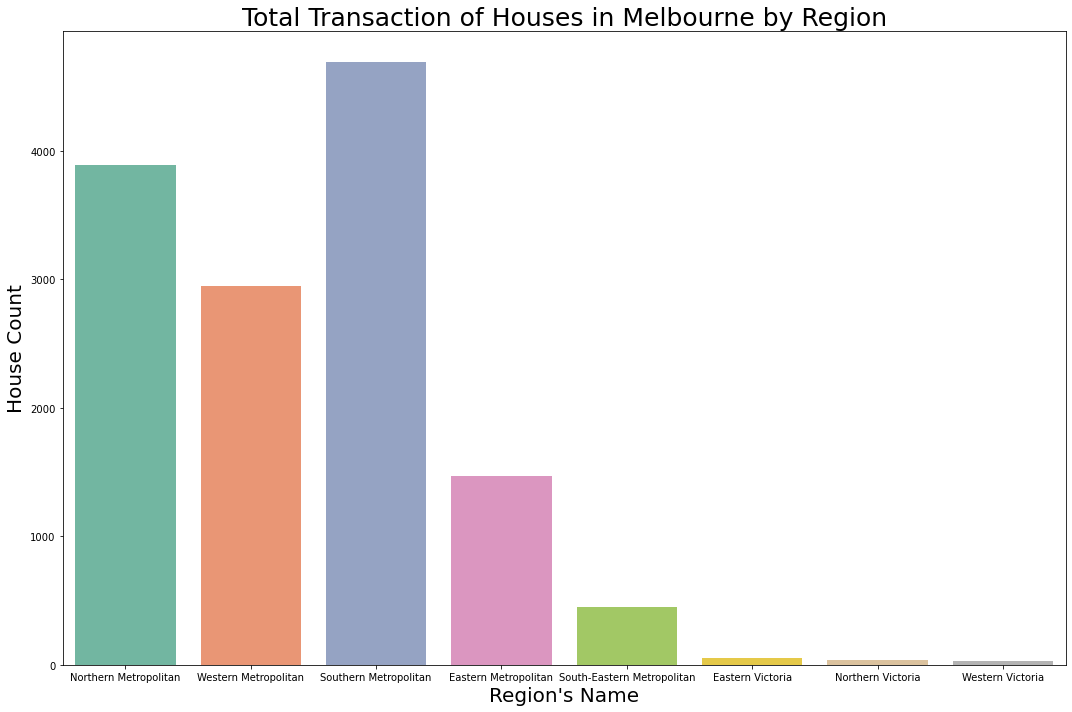

In [19]:
plt.figure(figsize=(15,10))
sns.countplot(data=df,x='Regionname',palette='Set2')
plt.xlabel("Region's Name", size=20)
plt.ylabel("House Count", size=20)
plt.title("Total Transaction of Houses in Melbourne by Region", size=25)
plt.tight_layout()

kita akan membandingkan harga rumah antar region

**Hypothesis**

Ho: tidak terdapat perbedaan nilai median harga rumah di setiap region
    
Ha: setidaknya ada satu pasang antara setiap region yang memiliki nilai median berbeda ( tidak diketahui yang mana dan bagaimana perbedaannya)

In [20]:
stats,pval= kruskal(*[df[df['Regionname']==i]['Price'] for i in list(df['Regionname'].unique())])
print (pval)

if pval<=0.05:
    print ('Tolak Ho karena P-value lebih kecil dari 0.05')
else :
    print ('Terima Ho karena P-value lebih besar dari 0.05')

0.0
Tolak Ho karena P-value lebih kecil dari 0.05


Dari hasil uji statistik nya menunjukan setidaknya ada 1 region yang memiliki harga rumah lebih tinggi dibanding region lainnya, mari kita coba lihat dengan visualisasi regionname dengan price agar bisa mengetahui mana region yang memiliki rata-rata harga rumah paling besar

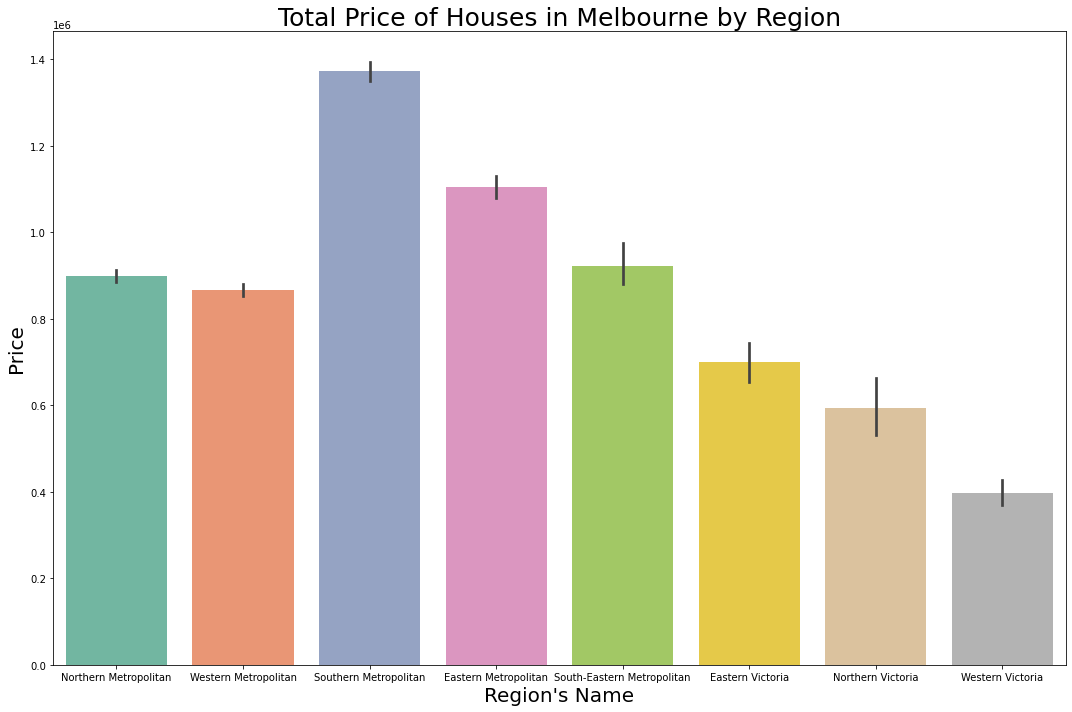

In [21]:
plt.figure(figsize=(15,10))
sns.barplot(data=df, x='Regionname',y='Price',palette='Set2')
plt.xlabel("Region's Name", size=20)
plt.ylabel("Price", size=20)
plt.title("Total Price of Houses in Melbourne by Region", size=25)
plt.tight_layout()

visualisasi jumlah transaksi rumah yang paling banyak terjual berada di region Metropolitan, jika diurutkan inilah 5 region dengan jumlah transaksi penjualan terbanyak :
1. Southern Metropolitan
2. Northern Metropolitan
3. Western Metropolitan
4. Eastern Metropolitan
5. SouthEastern Metropolitan

visualisasi harga rumah berdasarkan regionnya ini, jika kita urutan dari 5 regio dengan harga yang tertinggi :
1. Southern Metropolitan
2. Eastern Metropolitan
3. South-Easternrn Metropolitan
4. Northern Metropolitan
5. Western Metropolitan

jumlah transaksi penjualan, dan jumlah harga rumah di melbourne yang paling tinggi ada di melbourne, mungkin jika dilihat dari data ini masyarakat di melbourne tidak masalah dengan harga saat membeli rumah, tetapi ketika kita lihat jumlah transaksi penjualan kedua dan ketiga nya yaitu northern dan western metropolitan adalah peringkat kelima dari jumlah harga rumah berdasarkan regionnya. jadi bisa diasumsikan juga bahwa karena north dan west lebih murah dibanding east dan southeast metropolitan, jadi membeli rumah di region tersebut lebih di minati

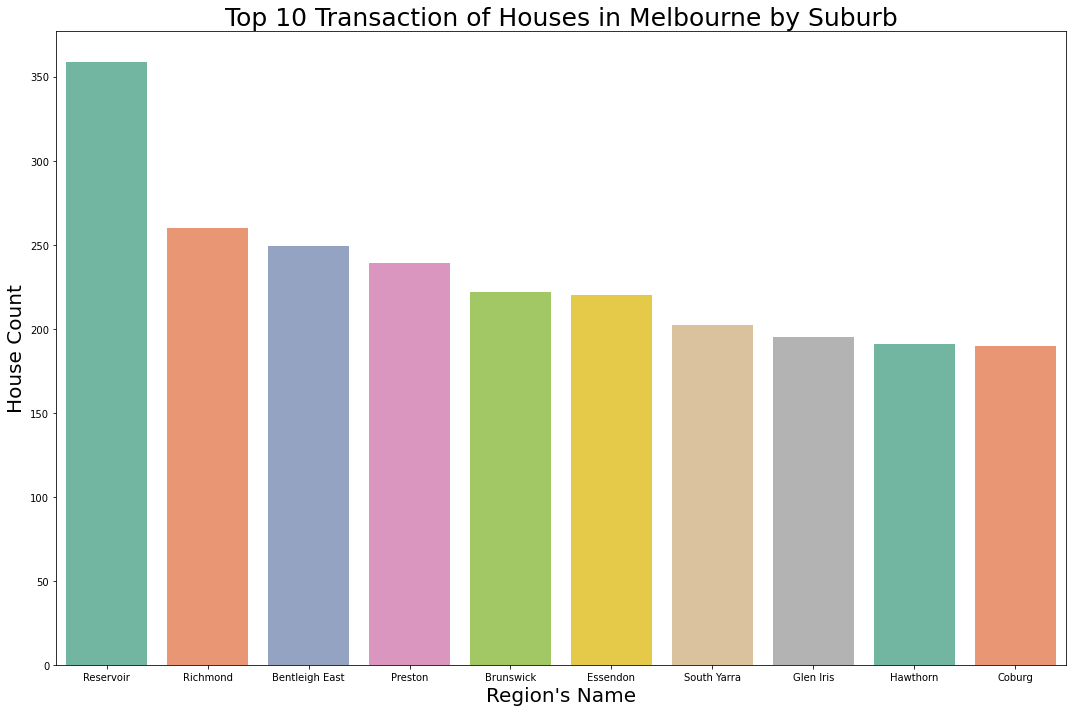

In [22]:
plt.figure(figsize=(15,10))
sns.countplot(data=df,x='Suburb',palette='Set2',order=df.Suburb.value_counts().iloc[:10].index)
plt.xlabel("Region's Name", size=20)
plt.ylabel("House Count", size=20)
plt.title("Top 10 Transaction of Houses in Melbourne by Suburb", size=25)
plt.tight_layout()

kita akan membandingkan harga rumah antar Suburb

**Hypothesis**

Ho: tidak terdapat perbedaan nilai median harga rumah di setiap Suburb
    
Ha: setidaknya ada satu pasang antara setiap suburb yang memiliki nilai median berbeda ( tidak diketahui yang mana dan bagaimana perbedaannya)

In [23]:
stats,pval= kruskal(*[df[df['Suburb']==i]['Price'] for i in list(df['Suburb'].unique())])
print (pval)

if pval<=0.05:
    print ('Tolak Ho karena P-value lebih kecil dari 0.05')
else :
    print ('Terima Ho karena P-value lebih besar dari 0.05')

0.0
Tolak Ho karena P-value lebih kecil dari 0.05


Dari uji Kruskalwallis bisa kita punya cukup bukti untuk menolak Ho, karena itu bisa diasumsikan bahwa terdapat perbedaan harga pada suburb

## Price by Type

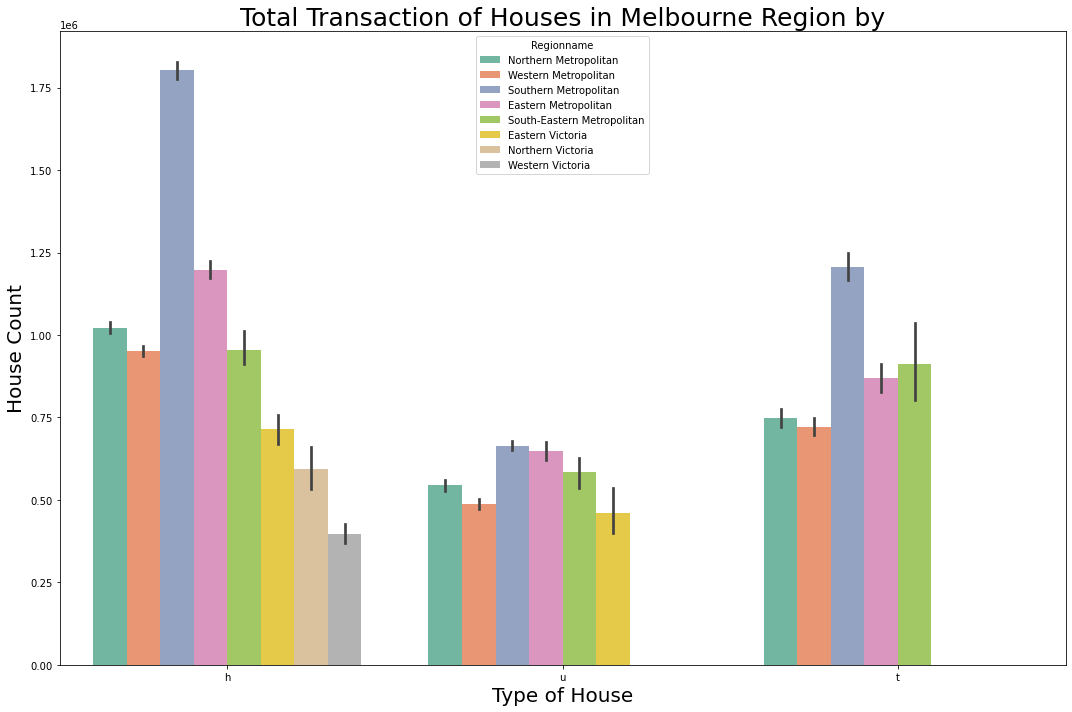

In [24]:
plt.figure(figsize=(15,10))
sns.barplot(data=df,hue='Regionname',y='Price',x='Type',palette='Set2')
plt.xlabel("Type of House", size=20)
plt.ylabel("House Count", size=20)
plt.title("Total Transaction of Houses in Melbourne Region by", size=25)
plt.tight_layout()

* U adalah Unit atau duplex
* H adalah House
* T adalah Townhouse

In [25]:
pd.crosstab(df['Regionname'],df['Type'])

Type,h,t,u
Regionname,,,
Eastern Metropolitan,1173,118,180
Eastern Victoria,50,0,3
Northern Metropolitan,2754,307,829
Northern Victoria,41,0,0
South-Eastern Metropolitan,388,25,37
Southern Metropolitan,2721,425,1549
Western Metropolitan,2290,239,419
Western Victoria,32,0,0


Dari visualisasi tentang harga tiap tipe rumah dan tipe rumah berdasarkan region bisa di asumsikan bahwa :
* Jika ingin membeli rumah di Southern Metropolitan yang diamana analsis sebelumnya bahwa di region ini harga rumah cukup tinggi dengan harga yang lebih murah, bisa memilih tipe rumah Unit / Duplex, selain lebih murah ketersediaanya juga cukup banyak di kota ini
* Jika ingin membeli rumah dengan harga yang paling terjangkau bisa membeli di Western Victoria, tetapi ketersediaannya cukup sedikit
* jika ingin membeli rumah dengan ketersediaan yang cukup banyak tetapi harga nya lebih rendah daripada southern metropolitan, bisa disarankan untuk membeli di northern atau western metropilitan.
* Jika ingin tinggal di tipe rumah townhuse, region yang memiliki ketersediaan cukup hanya di region Metropolitan dan paling banyak ada di southern metropolitan.

## Price by Distance
Kita melakukan uji statistik untuk mengetahui korelasi antara jarak dengan harga rumah

In [26]:
df[['Distance','Price']].corr(method='spearman')

,Distance,Price
Distance,1.00000,-0.12999
Price,-0.12999,1.00000


Dari hasil uji korelasi nya menggunakan spearman karena distribusi data tidak normal, terlihat bahwa korelasi antara jarak rumah dengan CBD sangat tinggi tetapi berbanding terbalik. Sehingga dapat dipastikan bahwa semakin dekat jarak rumah ke CBD maka harga rumah akan semakin mahal, begitu pula sebaliknya semakin jauh jarak rumah dengan CBD semakin murah harga rumah

## Time Series Analyis

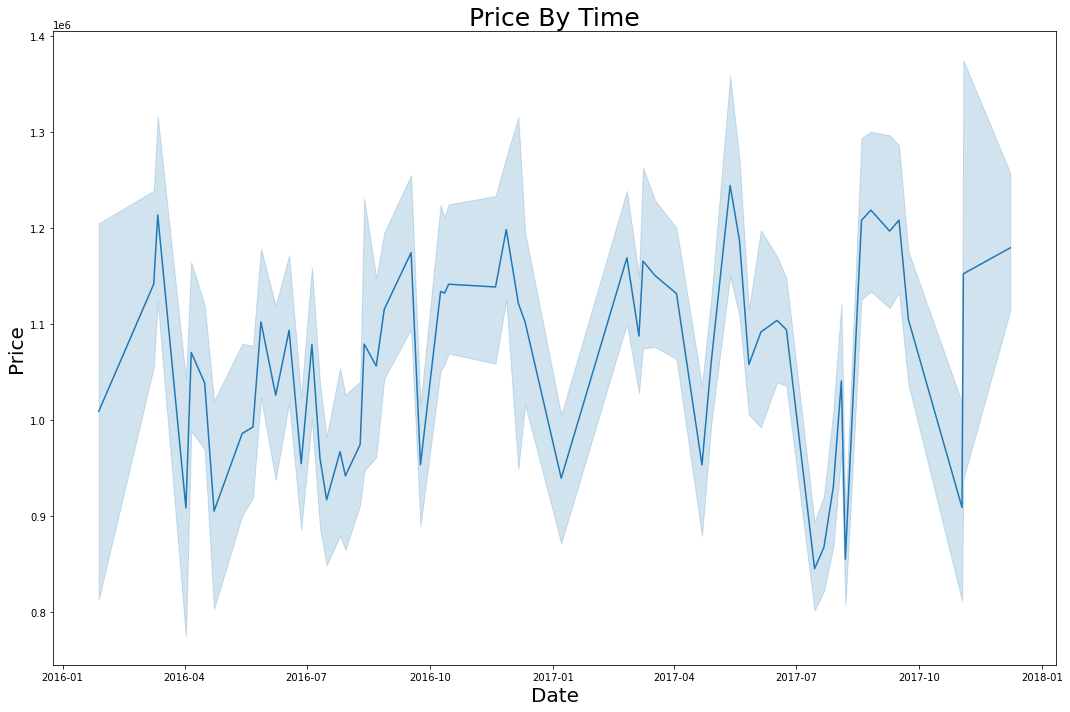

In [27]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df, x='Date',y='Price')
plt.xlabel("Date", size=20)
plt.ylabel("Price", size=20)
plt.title("Price By Time", size=25)
plt.tight_layout()

Tren dari harga rumah pasif atau tidak ada kenaikan signifikan dari tahun ke tahunnya. bahkan titik terendah harga rumah berada di tahun 2017. Jadi tidak ada hal khusus yang perlu dilakukan berdasarkan waktu karena kemungkinan waktu tidak mempengaruhi harga rumah

## Price by Rooms in the House

In [36]:
df[df['Bathroom']==0]
# Anomali data. sebanyak 34 rumah tidak memiliki kamar mandi

,Suburb,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,CouncilArea,Lattitude,Longtitude,Regionname,BuildingArea,Landsize,Rooms
139,Alphington,h,1485000.0,SP,McGrath,2016-08-28,6.4,3078.0,0,0,Darebin,-37.77810,145.02840,Northern Metropolitan,120.800,597.0,3
281,Armadale,u,546000.0,SP,hockingstuart,2016-07-30,6.3,3143.0,0,0,Stonnington,-37.85680,145.01610,Southern Metropolitan,370.000,0.0,2
505,Balaclava,u,497500.0,PI,hockingstuart,2016-08-28,6.6,3183.0,0,0,Port Phillip,-37.87390,144.99290,Southern Metropolitan,370.000,0.0,2
584,Balwyn,h,1010000.0,PI,Marshall,2016-07-30,9.7,3103.0,0,0,Boroondara,-37.80920,145.10160,Southern Metropolitan,97.800,1611.0,2
913,Bentleigh East,h,700000.0,S,Thomson,2016-05-22,13.9,3165.0,0,0,Glen Eira,-37.93140,145.08080,Southern Metropolitan,140.200,456.0,3
1063,Brighton,h,1900000.0,S,Marshall,2016-06-08,11.2,3186.0,0,0,Bayside,-37.93010,144.99350,Southern Metropolitan,123.200,0.0,3
1070,Brighton,t,1067000.0,S,Kay,2016-07-05,11.2,3186.0,0,1,Bayside,-37.91190,144.98710,Southern Metropolitan,123.200,0.0,3
1593,Camberwell,h,1400000.0,PI,Jellis,2016-04-16,7.8,3124.0,0,0,Boroondara,-37.83600,145.09140,Southern Metropolitan,175.400,693.0,4
2253,Elsternwick,u,410000.0,VB,Gary,2016-05-28,8.5,3185.0,0,0,Glen Eira,-37.88630,144.99960,Southern Metropolitan,370.000,0.0,2
2777,Glen Iris,h,845000.0,S,Noel,2016-10-09,9.2,3146.0,0,0,Stonnington,-37.86300,145.05010,Southern Metropolitan,95.200,207.0,2


### Average house price by number of rooms

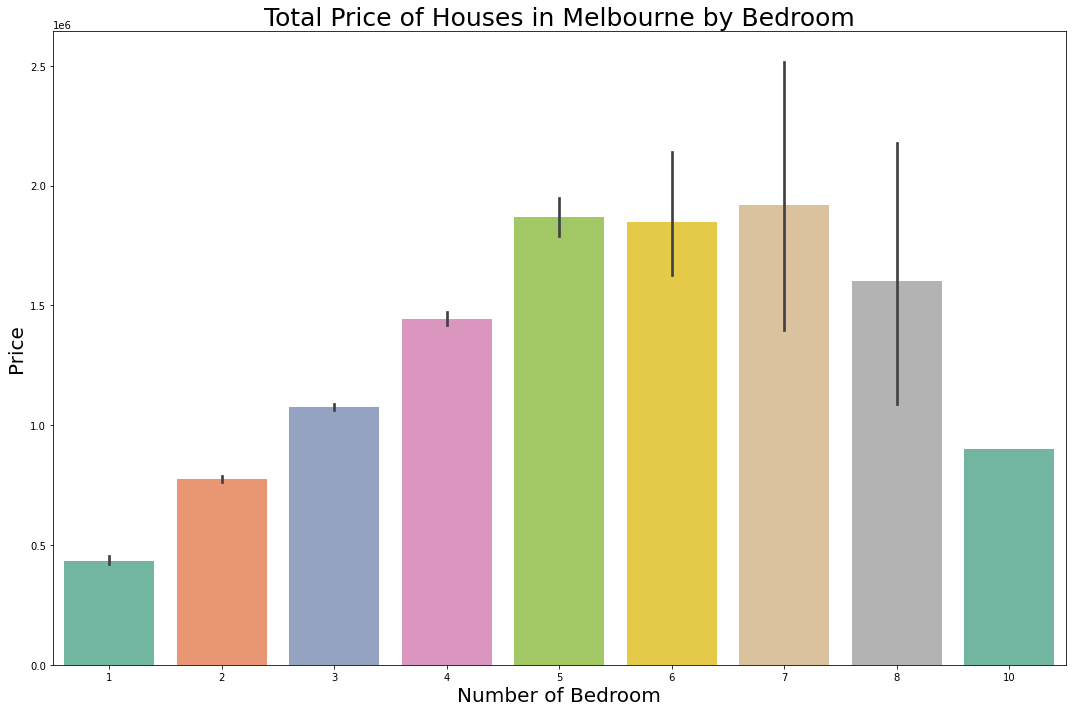

In [42]:
plt.figure(figsize=(15,10))
sns.barplot(data=df,x='Rooms',y='Price',palette='Set2')
plt.xlabel("Number of Bedroom", size=20)
plt.ylabel("Price", size=20)
plt.title("Total Price of Houses in Melbourne by Bedroom", size=25)
plt.tight_layout()

In [37]:
df.groupby('Rooms',as_index=False)[['Price']].mean()

,Rooms,Price
0,1,4.338245e+05
1,2,7.750812e+05
2,3,1.076081e+06
3,4,1.445282e+06
4,5,1.870260e+06
5,6,1.849366e+06
6,7,1.920700e+06
7,8,1.602750e+06
8,10,9.000000e+05


### Average house price by number of Bathroom

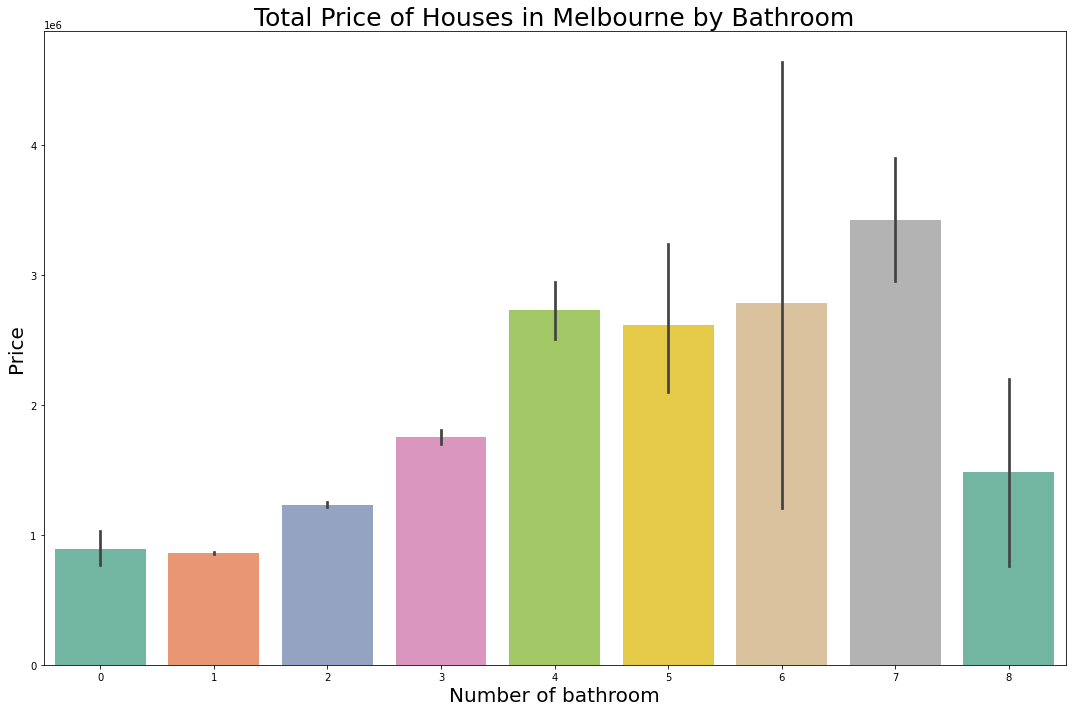

In [43]:
plt.figure(figsize=(15,10))
sns.barplot(data=df,x='Bathroom',y='Price',palette='Set2')
plt.xlabel("Number of bathroom", size=20)
plt.ylabel("Price", size=20)
plt.title("Total Price of Houses in Melbourne by Bathroom", size=25)
plt.tight_layout()

In [38]:
df.groupby('Bathroom',as_index=False)[['Price']].mean()

,Bathroom,Price
0,0,8.945588e+05
1,1,8.590896e+05
2,2,1.232027e+06
3,3,1.755633e+06
4,4,2.725852e+06
5,5,2.614179e+06
6,6,2.786200e+06
7,7,3.425000e+06
8,8,1.480000e+06


### Average house price by number of Carport

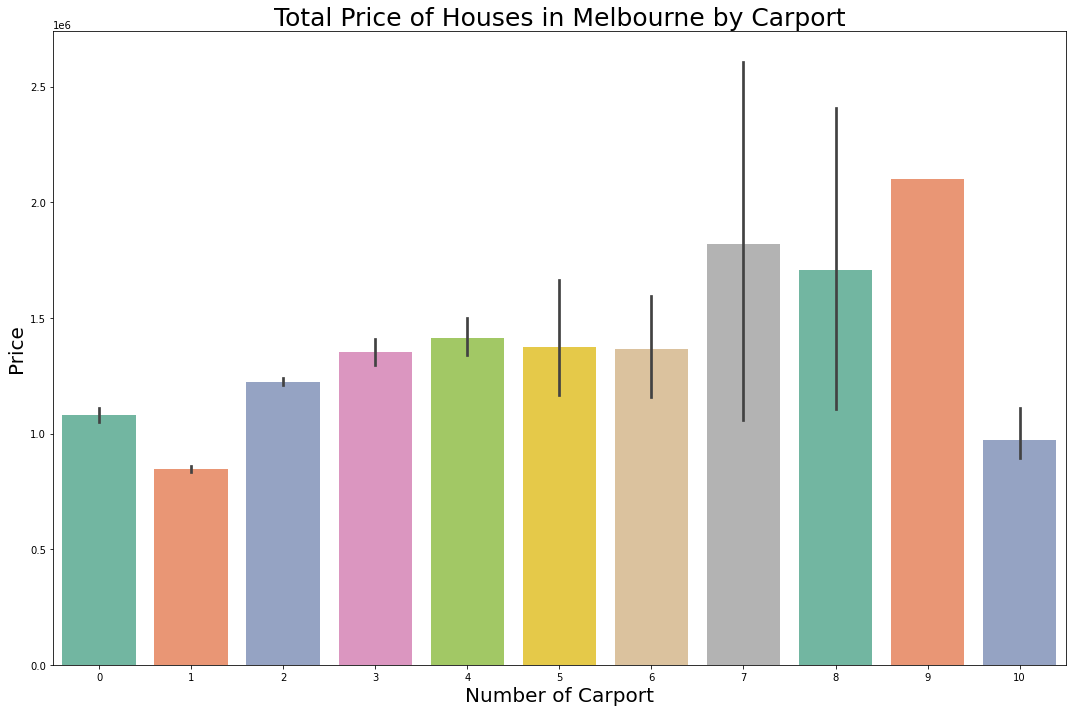

In [44]:
plt.figure(figsize=(15,10))
sns.barplot(data=df,x='Car',y='Price',palette='Set2')
plt.xlabel("Number of Carport", size=20)
plt.ylabel("Price", size=20)
plt.title("Total Price of Houses in Melbourne by Carport", size=25)
plt.tight_layout()

In [39]:
df.groupby('Car',as_index=False)[['Price']].mean()

,Car,Price
0,0,1.079088e+06
1,1,8.463654e+05
2,2,1.223177e+06
3,3,1.353753e+06
4,4,1.414014e+06
5,5,1.376071e+06
6,6,1.364130e+06
7,7,1.821438e+06
8,8,1.706333e+06
9,9,2.100000e+06


Dari ketiga visualisasi diatas tentang harga rumah berdasarkan jumlah kamar, kamar mandi dan parkirannya kita dapat melihat awalnya semakin banyak jumlah ruangannya harga rumah di melbourne akan semakin banyak.Tetapi ketika jumlah nya kamar dan kamar mandi nya lebih dari 7 harga nya menjadi turun. kemungkinan karena daya beli yang lebih sedikit ketika terlalu banyak ruangan

<AxesSubplot:>

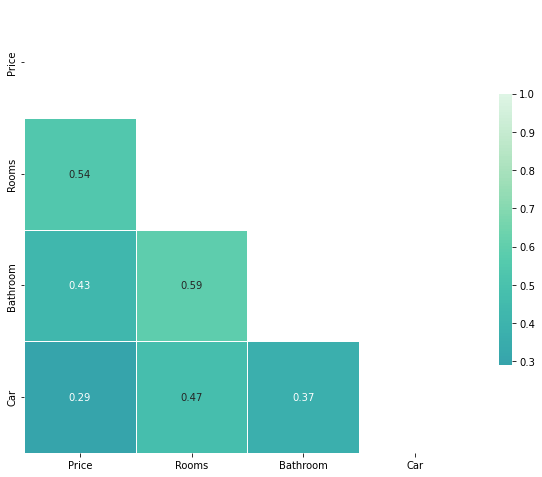

In [49]:
mask = np.triu(np.ones_like(df[['Price','Rooms','Bathroom','Car']].corr('spearman'), dtype=bool))

f, ax = plt.subplots(figsize=(10,10))

sns.heatmap(df[['Price','Rooms','Bathroom','Car']].corr('spearman'), mask=mask, cmap='mako',annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Dari hasil uji korelasi dapat disimpulkan bahwa:
* Korelasi antara jumlah kamar dengan harga rumah sedang dan berbanding lurus, berarti ketika semakin banyak kamar semakin besar pula harganya
* Korelasi antara jumlah kamar mandi dengan harga rumah sedang dan berbanding lurus, berarti ketika semakin banyak kamar mandi semakin besar pula harganya
* Korelasi antara Parkiran dengan harga rumah lemah

In [50]:
df.head()

,Suburb,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,CouncilArea,Lattitude,Longtitude,Regionname,BuildingArea,Landsize,Rooms
0,Abbotsford,h,1480000.0,S,Biggin,2016-03-12,2.5,3067.0,1,1,Yarra,-37.7996,144.9984,Northern Metropolitan,124.4,202.0,2
1,Abbotsford,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,1,0,Yarra,-37.8079,144.9934,Northern Metropolitan,79.0,156.0,2
2,Abbotsford,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067.0,2,0,Yarra,-37.8093,144.9944,Northern Metropolitan,150.0,134.0,3
3,Abbotsford,h,850000.0,PI,Biggin,2017-04-03,2.5,3067.0,2,1,Yarra,-37.7969,144.9969,Northern Metropolitan,147.6,94.0,3
4,Abbotsford,h,1600000.0,VB,Nelson,2016-04-06,2.5,3067.0,1,2,Yarra,-37.8072,144.9941,Northern Metropolitan,142.0,120.0,4


## Price by Landsize and Building Area

<AxesSubplot:>

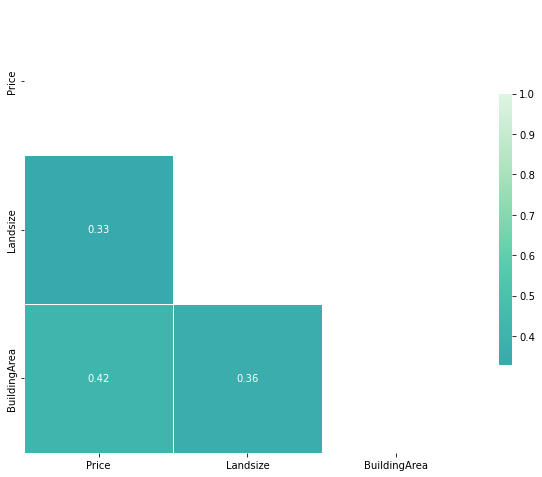

In [53]:
mask = np.triu(np.ones_like(df[['Price','Landsize','BuildingArea']].corr('spearman'), dtype=bool))

f, ax = plt.subplots(figsize=(10,10))

sns.heatmap(df[['Price','Landsize','BuildingArea']].corr('spearman'), mask=mask, cmap='mako',annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [68]:
df.groupby(['Regionname','Type']).mean()[['Distance','Price','Landsize','BuildingArea','Rooms','Bathroom','Car']]

Distance         Price     Landsize  \
Regionname                 Type                                         
Eastern Metropolitan       h     14.117903  1.197450e+06   717.422847   
                           t     13.257627  8.696199e+05   269.440678   
                           u     12.910000  6.493144e+05   330.444444   
Eastern Victoria           h     33.842000  7.142996e+05  3108.960000   
                           u     40.333333  4.613333e+05   295.333333   
Northern Metropolitan      h      8.877233  1.021222e+06   619.249092   
                           t      7.567752  7.496083e+05   317.325733   
                           u      5.613390  5.444038e+05   495.026538   
Northern Victoria          h     33.748780  5.948293e+05  3355.463415   
South-Eastern Metropolitan h     24.058505  9.559496e+05   664.306701   
                           t     21.588000  9.132700e+05   212.160000   
                           u     22.748649  5.833649e+05   357.864865   
Southern Metropolitan      h      9.331165  1.802241e+06   569.643881   
                           t     10.232706  1.205404e+06   278.858824   
                           u      7.342479  6.648600e+05   466.380245   
Western Metropolitan       h     10.459476  9.507663e+05   507.883406   
                           t      9.197071  7.209510e+05   244.560669   
                           u      8.682578  4.884144e+05   557.637232   
Western Victoria           h     30.753125  3.975234e+05   655.500000   

                                 BuildingArea     Rooms  Bathroom       Car  
Regionname                 Type                                              
Eastern Metropolitan       h       189.306029  3.507246  1.757886  1.890026  
                           t       136.628508  2.991525  1.813559  1.635593  
                           u       140.433500  2.333333  1.238889  1.266667  
Eastern Victoria           h       539.113240  3.440000  1.860000  2.100000  
                           u       115.733333  2.666667  1.000000  1.333333  
Northern Metropolitan      h       151.624259  3.044662  1.404139  1.587146  
                           t       130.984580  2.534202  1.602606  1.312704  
                           u       121.921602  1.876960  1.160434  1.078408  
Northern Victoria          h      1457.894634  3.560976  1.853659  1.926829  
South-Eastern Metropolitan h       179.183163  3.492268  1.685567  2.128866  
                           t       140.837408  2.840000  1.840000  1.680000  
                           u       142.037243  2.324324  1.243243  1.405405  
Southern Metropolitan      h       183.581104  3.371187  1.821022  1.812201  
                           t       149.679668  2.995294  1.948235  1.729412  
                           u       144.010438  1.927695  1.189154  1.127179  
Western Metropolitan       h       158.994139  3.213100  1.526201  1.817467  
                           t       139.540059  2.870293  1.824268  1.506276  
                           u       142.941508  2.073986  1.178998  1.150358  
Western Victoria           h       138.031625  3.406250  1.468750  1.843750

# Summary

Dari keseluruhan analysis dapat di simpulkan bahwa hal yang sangat mempengaruhi harga rumah adalah Region nya. Hal tersebut tentu masuk akal karena region metropolitan berada di dekat CBD (central business district), fasilitas yang tersedia di dekat CBD pasti lebih baik dibanding fasilitas di daerah yang jauh dari CBD. Tipe rumah juga sangat mempengaruhi harga jual sedangkan waktu, luas tanah dan bangunan, dan jumlah ruangan jika berdasarkan hasil korelasi nya memiliki pengaruh yang sedang saja atau tidak terlalu besar.

Dapat di **rekomendasikan** untuk calon pembeli rumah di kota melbourne :

* Jika ingin membeli rumah di dekat CBD bisa membeli di Northern Metropolitan. Di region ini ketersediaan rumah, townhouse dan duplex nya cukup banyak, harganya pun lebih rendah dibanding  Western dan Southern Metropolitan. Mungkin karena rata-rata luas bangunan nya lebih kecil di banding rata-rata luas bangunan di western dan southern metropolitan.

* Jika ingin membeli rumah yang termurah, bisa membeli rumah di western victoria. anda dapat membeli rumah dengan luas tanah yang cukup besar dengan harga yang cukup terjangkau, lebih murah di bandingkan harga unit di seluruh region metropolitan. Tetapi untuk membeli rumah disini berarti anda membeli rumah yang jaraknya cukup jauh dari CBD

* Jika ingin membeli rumah yang Termahal, bisa membeli rumah di daerah Southern Metropolitan. bahkan harga 1 duplex disini setara dengan membeli 3 rumah di western victoria. harus dianalisa lebih lanjut diluar data ini mengapa rumah di southern metropolitan sangat mahal.

* Jika ingin membeli rumah yang jauh dari keramaian atu jauh dari CBD anda dapat membeli rumah di eastern victoria. dengan mengeluarkan uang yang sama besar dengan membeli rumah Townhouse di  Northern Metropolitan(terdekat ke CBD), anda bisa membeli rumah dengan luas tanah mencapai 3000

